# Simulation Diagnostics

In [1]:
from bunch import Bunch
from functools import partial
import json
import palettable
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pneumodel.plotting import remove_spines, save_figure
import re

/Users/ocsicnarf/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


## Setup

In [2]:
%matplotlib inline
SET1_COLORS     = palettable.colorbrewer.qualitative.Set1_9.mpl_colors
DARK2_COLORS    = palettable.colorbrewer.qualitative.Dark2_8.mpl_colors
PAIRED12_COLORS = palettable.colorbrewer.qualitative.Paired_12.mpl_colors

In [21]:
RUN_NAME   = "wcv-trial-kenya-beta-0.1"
TRIAL_NAME = 'trial-0'
OUTPUT_DIR = os.path.join('/Volumes/Samsung USB/WCV-PAPER/', RUN_NAME)
TRIAL_DIR  = os.path.join(OUTPUT_DIR, TRIAL_NAME)

In [22]:
save_fig = partial(save_figure, folder=os.path.join(OUTPUT_DIR, 'figures', TRIAL_NAME.replace('/', '-')), exts=['pdf', 'png'])

In [23]:
def read_json(key, *path_components):
  with open(os.path.join(*path_components)) as f:
    return np.array(json.load(f)[key])

def read_csv(*path_components):
  return np.array(pd.read_csv(os.path.join(*path_components), header=None))

#### Configuration

In [24]:
with open(os.path.join(OUTPUT_DIR, 'configuration', 'configuration.json')) as f:
    CONFIG = json.load(f, object_hook=lambda d: Bunch(d))

MAX_AGE = CONFIG.population.max_age
print CONFIG.host
print CONFIG.population

epsilon: 0.1
halflife_sg: -1
halflife_st: -1
mu: 0.25
sigma_sg: 0.0
sigmas_file: sigmas_kenya.json

age_mixing_file: mixing_kenya.json
beta: 0.1
initial_colonization_prob: 0.02
lifespan_pmf_file: lifespan_pmf_pyramid_kenya.json
max_age: 101
omega: 1.0e-06



In [25]:
SEROTYPES     = read_json('serotypes', OUTPUT_DIR, 'configuration', CONFIG.serotype.serotypes_file).flatten()
RANKS         = read_json('ranks',     OUTPUT_DIR, 'configuration', CONFIG.serotype.ranks_file).flatten()
NUM_SEROTYPES = len(SEROTYPES)
ST2COLOR      = { s : DARK2_COLORS[s % len(DARK2_COLORS)] for s in range(NUM_SEROTYPES)}
print NUM_SEROTYPES, 'serotypes'

56 serotypes


In [26]:
VACCINATION_PROGRAMS = CONFIG.simulation.vaccinations
get_targeted_serotypes = lambda program: filter(lambda v: v.name == program.vaccine, CONFIG.vaccines)[0].susceptibility_reduction.serotypes
get_program_start_year = lambda program: program.start_year + program.start_day / 365.
get_program_end_year   = lambda program: program.start_year + program.start_day / 365. + program.duration

In [27]:
VACCINATION_PROGRAMS

[]

#### Demographic Data

In [28]:
NUM_HOSTS        = read_csv(TRIAL_DIR, 'num_hosts.csv').flatten()
NUM_HOSTS_BY_AGE = read_csv(TRIAL_DIR, 'num_hosts_by_age.csv')
NUM_YEARS        = NUM_HOSTS_BY_AGE.shape[0]

Population size over time

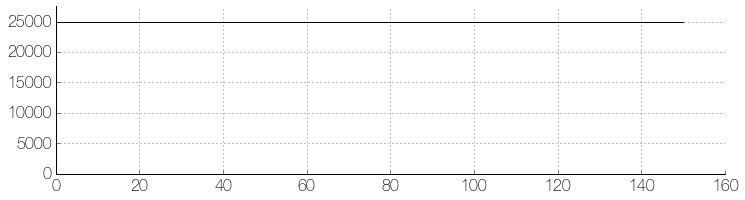

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(12, 3))
ax.plot(NUM_HOSTS)
ax.grid(True)
ax.set_ylim(0, max(NUM_HOSTS) * 1.1)
remove_spines(ax)

Stack plot of 10-year age groups

In [30]:
NUM_HOSTS_10YR_AGE_GROUPS = [np.sum(NUM_HOSTS_BY_AGE[:, i:i+10], axis=1) for i in np.arange(0, MAX_AGE, 10)]

['/Volumes/Samsung USB/WCV-PAPER/wcv-trial-kenya-beta-0.1/figures/trial-0/age-composition-0.pdf',
 '/Volumes/Samsung USB/WCV-PAPER/wcv-trial-kenya-beta-0.1/figures/trial-0/age-composition-0.png']

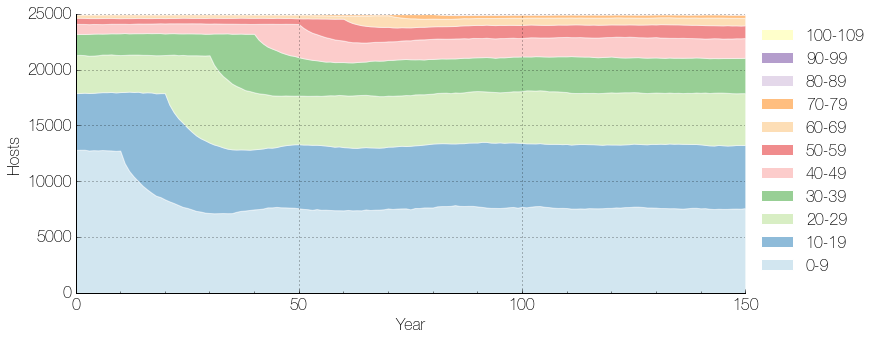

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
years = np.arange(NUM_YEARS)
ax.set_color_cycle(PAIRED12_COLORS)
stack_coll = ax.stackplot(years, *NUM_HOSTS_10YR_AGE_GROUPS, alpha=0.5)

label_list = ['{}-{}'.format(i, i + 9) for i in np.arange(0, MAX_AGE, 10)]
proxy_rects = [mpl.patches.Rectangle((0, 0), 1, 1, fc=p.get_facecolor()[0]) for p in stack_coll ]
ax.legend(proxy_rects[::-1], label_list[::-1], bbox_to_anchor=(1.20, 1.0))

ax.set_ylabel('Hosts')
ax.set_xlabel('Year')
ax.set_xlim(0, np.max(years))
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(50))
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(10))
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(10))

ax.grid(True)
remove_spines(ax)
save_fig(fig, "age-composition")

Population pyramid. Compare against http://populationpyramid.net/kenya/2015/ or https://populationpyramid.net/united-states-of-america/2016/

In [32]:
NUM_HOSTS_5YR_AGE_GROUPS = [np.sum(NUM_HOSTS_BY_AGE[:, i:i+5], axis=1) for i in np.arange(0, MAX_AGE, 5)]

In [33]:
pyramid = np.array([n[-1] for n in NUM_HOSTS_5YR_AGE_GROUPS])
pyramid = pyramid.astype(float) / np.sum(pyramid)

['/Volumes/Samsung USB/WCV-PAPER/wcv-trial-kenya-beta-0.1/figures/trial-0/population-pyramid-0.pdf',
 '/Volumes/Samsung USB/WCV-PAPER/wcv-trial-kenya-beta-0.1/figures/trial-0/population-pyramid-0.png']

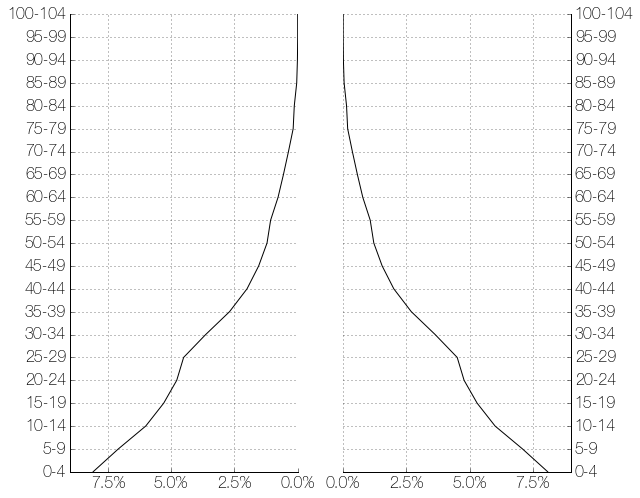

In [34]:
fig, axes = plt.subplots(1, 2, figsize=(9, 7), sharey=True)
ax = axes[0]
ax.plot(pyramid / 2, np.arange(pyramid.shape[0]))
ax.invert_xaxis()
ax.yaxis.grid(True)
remove_spines(ax)

ax = axes[1]
ax.plot(pyramid / 2, np.arange(pyramid.shape[0]))
remove_spines(ax, bottom=True, right=True, left=False)

for ax in axes:
    ax.grid(True)
    ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(1))
    ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(0.025))
    ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: "{}%".format(100 * x)))
    ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda y, p: "{:.0f}-{:.0f}".format(y * 5, y * 5 + 4 )))
fig.tight_layout()
save_fig(fig, "population-pyramid")

#### Vaccination

In [35]:
NUM_VACCINATED_13MO = [read_csv(TRIAL_DIR, 'num_vaccinated_13mo_{}.csv'.format(p.vaccine)) for p in VACCINATION_PROGRAMS]
NUM_VACCINATED_U5 = [read_csv(TRIAL_DIR, 'num_vaccinated_under_5_{}.csv'.format(p.vaccine)) for p in VACCINATION_PROGRAMS]
NUM_HOSTS_13MO = read_csv(TRIAL_DIR, 'num_hosts_13mo.csv')

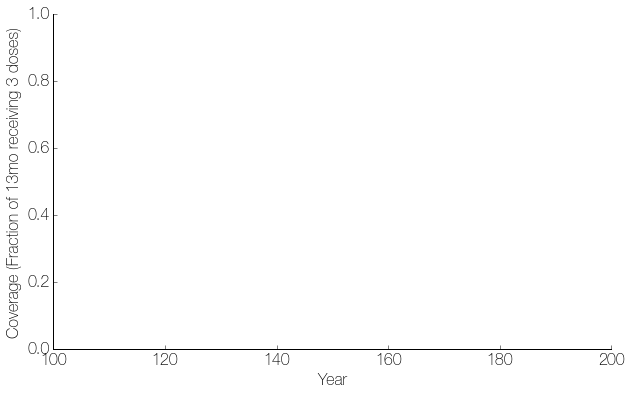

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
for i, program in enumerate(VACCINATION_PROGRAMS):
    ax.plot(NUM_VACCINATED_13MO[i] / NUM_HOSTS_13MO.astype(float), marker='o')
    ax.plot(np.arange(len(program.coverage)) + get_program_start_year(program) + (419. / 365),
            program.coverage, alpha=0.5, color='b', marker='o')
ax.set_xlim(100, 200)
ax.set_ylabel("Coverage (Fraction of 13mo receiving 3 doses)")
ax.set_xlabel("Year")
remove_spines(ax)

#### Colonization Dynamics

Prevalence Dynamics in General Population and in Children under 5

In [37]:
NUM_COLONIZED = np.zeros(shape=(NUM_YEARS, NUM_SEROTYPES, MAX_AGE + 1))
for i in range(NUM_SEROTYPES):
  NUM_COLONIZED[:,i,:] = read_csv(TRIAL_DIR, 'num_colonized_by_age_ss_' + SEROTYPES[i] + '.csv')

#NUM_PREV_COLONIZED = np.zeros(shape=(NUM_YEARS, NUM_SEROTYPES, MAX_AGE + 1))
#for i in range(NUM_SEROTYPES):
#  NUM_PREV_COLONIZED[:,i,:] = read_csv(TRIAL_DIR, 'num_previously_colonized_by_age_ss_' + SEROTYPES[i] + '.csv')
    
NUM_COLONIZED_ALL_AGES = NUM_COLONIZED.sum(axis=2)
NUM_COLONIZED_OVERALL  = read_csv(TRIAL_DIR, 'num_colonized.csv').flatten()
NUM_COLONIZED_UNDER_5  = read_csv(TRIAL_DIR, 'num_colonized_under_5.csv').flatten()
NUM_HOSTS_UNDER_5      = NUM_HOSTS_BY_AGE[:,:5].sum(axis=1)

0.26028
0.547533588001


['/Volumes/Samsung USB/WCV-PAPER/wcv-trial-kenya-beta-0.1/figures/trial-0/total-prevalence-0.pdf',
 '/Volumes/Samsung USB/WCV-PAPER/wcv-trial-kenya-beta-0.1/figures/trial-0/total-prevalence-0.png']

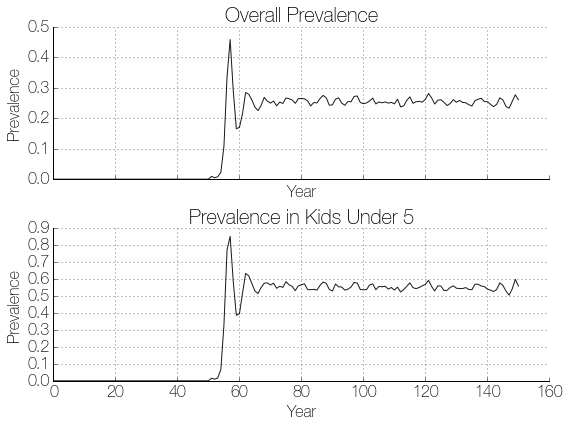

In [38]:
fig, axes = plt.subplots(2, 1, figsize=(8, 6), sharex=True, sharey=False)

ax = axes[0]
ax.set_title('Overall Prevalence')
prevalence = NUM_COLONIZED_OVERALL.astype(float) / NUM_HOSTS
print prevalence[-1]
ax.plot(prevalence[:], alpha=0.9)
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(6))

ax = axes[1]
ax.set_title('Prevalence in Kids Under 5')
prevalence_in_kids = NUM_COLONIZED_UNDER_5.astype(float) / NUM_HOSTS_UNDER_5
print prevalence_in_kids[-10:].mean()
ax.plot(prevalence_in_kids[:], alpha=0.9)
ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(0.1))

for ax in axes:
    ax.set_ylabel('Prevalence')
    ax.set_xlabel('Year')
    ax.grid(True)    
    remove_spines(ax)
    
    for p in VACCINATION_PROGRAMS:
        ax.axvspan(get_program_start_year(p), get_program_end_year(p), facecolor='.6')
        ax.text(get_program_start_year(p), ax.get_ylim()[1], p.vaccine, va='bottom', fontsize=10)

fig.tight_layout()

save_fig(fig, 'total-prevalence')

Prevalence Dynamics by Contact Age Groups

In [177]:
AGE_CUTOFFS = read_json('age_cutoffs', OUTPUT_DIR, 'configuration', CONFIG.population.age_mixing_file)
AGE_CUTOFFS = np.append(AGE_CUTOFFS, MAX_AGE)
AGE_CUTOFFS = np.insert(AGE_CUTOFFS, 0, 0)
AGE_CUTOFFS

array([  0,   1,   6,  15,  21,  50, 101])

In [178]:
SEROTYPES

array([u'1', u'10A', u'10B', u'10F', u'11A', u'11D', u'12B', u'12F', u'13',
       u'14', u'15A', u'15B', u'15C', u'15F', u'16F', u'17F', u'18B',
       u'18C', u'18F', u'19A', u'19B', u'19C', u'19F', u'20', u'21',
       u'22A', u'22F', u'23A', u'23B', u'23F', u'24F', u'28A', u'28F',
       u'29', u'3', u'31', u'33B', u'33C', u'33D', u'34', u'35A', u'35B',
       u'35F', u'38', u'4', u'40', u'5', u'6A', u'6B', u'7C', u'7F', u'8',
       u'9A', u'9L', u'9N', u'9V'], 
      dtype='<U3')

In [104]:
AGE_GROUPS = []
serotypes = SEROTYPES
for a, b in zip(AGE_CUTOFFS[:-1], AGE_CUTOFFS[1:]) + [(0, 5)]:
  group = Bunch(
    cutoffs = (a, b),
    num_hosts = NUM_HOSTS_BY_AGE[:,a:b + 1].sum(axis=1),
    num_colonized = Bunch()
  )
  group.num_colonized.all = NUM_COLONIZED[:,:, a:b + 1].sum(axis=(1, 2))
  for st in serotypes:
    s = np.where(SEROTYPES == st)[0][0]
    group.num_colonized[st] = NUM_COLONIZED[:,s, a:b + 1].sum(axis=1)
  AGE_GROUPS.append(group)

In [105]:
# fig, axes = plt.subplots(len(serotypes) + 1, 1, figsize=(10, len(serotypes) * 5))
# ax = axes[0]
# ax.set_title('Colonization by any serotype')
# ax.set_color_cycle(DARK2_COLORS)
# for i, g in enumerate(AGE_GROUPS):
#   if g.cutoffs != (0, 5):
#     ax.plot(g.num_colonized.all / g.num_hosts.astype(float), label='{}-{} years'.format(*g.cutoffs), lw=2)
#   else:
#     ax.plot(g.num_colonized.all / g.num_hosts.astype(float), label='{}-{} years'.format(*g.cutoffs), lw=2, c='k')

# for ax, st in zip(axes[1:], serotypes):
#   ax.set_title('Colonization by {}'.format(st))
#   ax.set_color_cycle(DARK2_COLORS)
#   for i, g in enumerate(AGE_GROUPS):
#     targeted = any(st in get_targeted_serotypes(p) for p in VACCINATION_PROGRAMS)
#     if g.cutoffs != (0, 5):
#       ax.plot(g.num_colonized[st] / g.num_hosts.astype(float), label='{}-{} years'.format(*g.cutoffs), lw=2)
#     else:
#       ax.plot(g.num_colonized[st] / g.num_hosts.astype(float), label='{}-{} years'.format(*g.cutoffs), lw=2, c='k')
  
# for ax in axes:
#   ax.set_xlim(NUM_YEARS - 125, NUM_YEARS)
#   ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(10))
#   ax.legend(loc='upper right', frameon=True)
#   ax.set_ylabel('Prevalence')
#   ax.set_xlabel('Simulation Year')
#   ax.grid(True)
#   remove_spines(ax)
#   ax.set_ylim(1e-4, 1.0)
#   ax.set_yscale('log')
    
# # add markers for vaccinations
# for ax in axes:
#   for p in VACCINATION_PROGRAMS:
#     ax.axvspan(get_program_start_year(p), get_program_end_year(p), facecolor='.8')
#     ax.text(get_program_start_year(p), ax.get_ylim()[1], p.vaccine, va='bottom', fontsize=10)
  
# fig.tight_layout()

# save_fig(fig, 'prevalence-dynamics-by-age-group')

### Prevalence Dynamics by Category

In [106]:
get_serogroup = lambda s: re.search('(\d+)\D*', s).group(1)

In [107]:
ALL_VACCINE_TYPES = reduce(lambda res, item: res | set(get_targeted_serotypes(p)), VACCINATION_PROGRAMS, set())

In [108]:
def get_category(s):
  if s in ALL_VACCINE_TYPES:
    return 'VT'
  elif any(get_serogroup(s) == get_serogroup(t) for t in ALL_VACCINE_TYPES):
    return 'VRT'
  else:
    return 'NVT'

get_category = np.vectorize(get_category)

In [109]:
NUM_COLONIZED_U5_VT  = NUM_COLONIZED[:,get_category(SEROTYPES) == 'VT', :5].sum(axis=(1, 2))
NUM_COLONIZED_U5_VRT = NUM_COLONIZED[:,get_category(SEROTYPES) == 'VRT',:5].sum(axis=(1, 2))
NUM_COLONIZED_U5_NVT = NUM_COLONIZED[:,get_category(SEROTYPES) == 'NVT',:5].sum(axis=(1, 2))

In [110]:
NUM_PREV_COLONIZED_U5_VT  = NUM_PREV_COLONIZED[:,get_category(SEROTYPES) == 'VT', :5].sum(axis=(1, 2))
NUM_PREV_COLONIZED_U5_VRT = NUM_PREV_COLONIZED[:,get_category(SEROTYPES) == 'VRT',:5].sum(axis=(1, 2))
NUM_PREV_COLONIZED_U5_NVT = NUM_PREV_COLONIZED[:,get_category(SEROTYPES) == 'NVT',:5].sum(axis=(1, 2))

/Users/ocsicnarf/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/ipykernel/__main__.py:1: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 1; dimension is 40 but corresponding boolean dimension is 56
  if __name__ == '__main__':
/Users/ocsicnarf/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/ipykernel/__main__.py:2: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 1; dimension is 40 but corresponding boolean dimension is 56
  from ipykernel import kernelapp as app
/Users/ocsicnarf/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/ipykernel/__main__.py:3: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 1; dimension is 40 but corresponding boolean dimension is 56
  app.launch_new_instance()


IndexError: index 40 is out of bounds for axis 1 with size 40

In [111]:
OBSERVED_COUNTS = read_json('counts', OUTPUT_DIR, 'configuration', CONFIG.fitting.observed_counts_file).astype(float)
OBSERVED_PREV = OBSERVED_COUNTS[:-1] / OBSERVED_COUNTS.sum()
OBSERVED_PREV_BY_CAT = Bunch()
for c in ('VT', 'VRT', 'NVT'):
  OBSERVED_PREV_BY_CAT[c] = OBSERVED_PREV[np.vectorize(get_category)(SEROTYPES) == c].sum()

AttributeError: fitting

In [30]:
OBSERVATION_YEAR = get_program_start_year(VACCINATION_PROGRAMS[0]) + 8

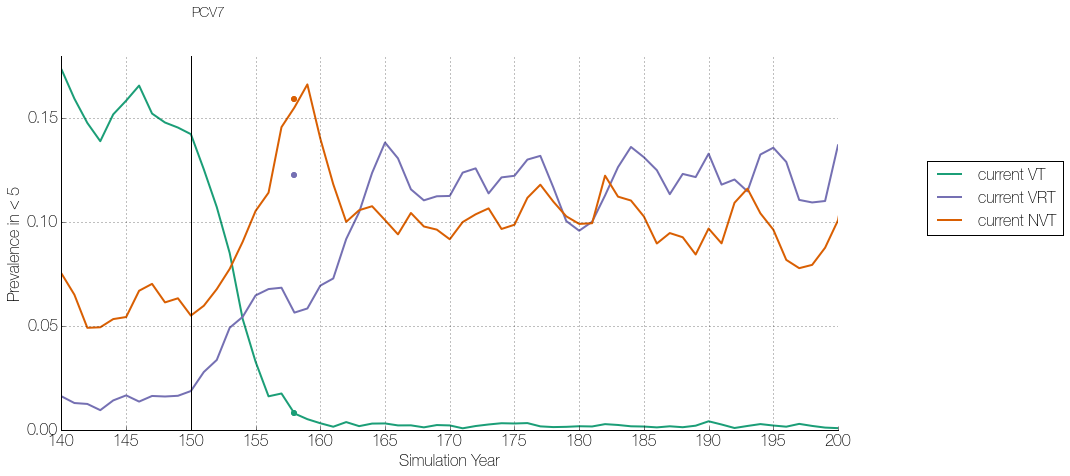

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.plot(NUM_COLONIZED_U5_VT  / NUM_HOSTS_UNDER_5, color=DARK2_COLORS[0], alpha=1, lw=2, label='current VT')
ax.plot(NUM_COLONIZED_U5_VRT / NUM_HOSTS_UNDER_5, c=DARK2_COLORS[2], lw=2, label='current VRT')
ax.plot(NUM_COLONIZED_U5_NVT / NUM_HOSTS_UNDER_5, c=DARK2_COLORS[1], lw=2, label='current NVT')

#ax.plot(NUM_PREV_COLONIZED_U5_VT  / NUM_HOSTS_UNDER_5, color=DARK2_COLORS[0], alpha=0.8, lw=2, label='past VT', ls='--')
#ax.plot(NUM_PREV_COLONIZED_U5_VRT / NUM_HOSTS_UNDER_5, c=DARK2_COLORS[2], lw=2, label='past VRT', ls='--')
#ax.plot(NUM_PREV_COLONIZED_U5_NVT / NUM_HOSTS_UNDER_5, c=DARK2_COLORS[1], lw=2, label='past NVT', ls='--')

ax.plot(OBSERVATION_YEAR, OBSERVED_PREV_BY_CAT.VT , color=DARK2_COLORS[0], alpha=1, lw=1, marker='o')
ax.plot(OBSERVATION_YEAR, OBSERVED_PREV_BY_CAT.VRT, color=DARK2_COLORS[2], lw=1, marker='o')
ax.plot(OBSERVATION_YEAR, OBSERVED_PREV_BY_CAT.NVT, color=DARK2_COLORS[1], lw=1, marker='o')

ax.set_ylabel('Prevalence in < 5')
ax.set_xlabel('Simulation Year')

ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(0.05))
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(5))
for p in VACCINATION_PROGRAMS:
  #ax.axvspan(get_program_start_year(p), get_program_end_year(p), facecolor='.7')
  ax.axvline(get_program_start_year(p), c='k')
  ax.text(get_program_start_year(p) + 0.1, ax.get_ylim()[1]*1.1, p.vaccine, va='bottom', fontsize=14)    
remove_spines(ax)
ax.grid(True)

vac_start = min(get_program_start_year(p) for p in VACCINATION_PROGRAMS)
ax.set_xlim(vac_start - 10, vac_start + 50)

#ax.set_yscale('log')
#ax.set_ylim(1e-5, 1)
#for i, p in enumerate(VACCINATION_PROGRAMS):
#  ax.plot(NUM_VACCINATED_U5[i].flatten() / NUM_HOSTS_UNDER_5.astype(float), lw=1.5, alpha=0.5, label='{} vaccine coverage'.format(p.vaccine))
  
lgd = ax.legend(loc='lower right',frameon=True, bbox_to_anchor=(1.3, 0.5))
fig.tight_layout()

#save_fig(fig, 'categorized-serotype-dynamics', additional_artists=(lgd,))

### Prevalence Dynamics by Serotype

In [ ]:
n_per_plot = 8
num_plots = int(math.ceil(NUM_SEROTYPES / float(n_per_plot)))

fig, axes = plt.subplots(num_plots, 1, figsize=(15, 20), sharex=True, sharey=False)
for i in range(NUM_SEROTYPES):        
    ax = axes[i / n_per_plot]
    
    targeted = any(SEROTYPES[i] in get_targeted_serotypes(p) for p in VACCINATION_PROGRAMS)
    ax.plot(NUM_COLONIZED_ALL_AGES[:, i],
            label='{}'.format(SEROTYPES[i]),
            color=ST2COLOR[i],
            ls=(':' if targeted else '-'),
            lw=1.5,
            alpha=0.9)
    
    ax.set_ylabel('# Colonized')
    ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(6))
    ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(20))
    ax.legend(bbox_to_anchor=(1.08, 1.05))
    ax.grid(True, ls='-', alpha=0.3)
    remove_spines(ax)

# add markers for vaccinations
for ax in axes:
    for p in VACCINATION_PROGRAMS:
        ax.axvspan(get_program_start_year(p), get_program_end_year(p), facecolor='.8')
        ax.text(get_program_start_year(p), ax.get_ylim()[1], p.vaccine, va='bottom', fontsize=10)
    
axes[-1].set_xlabel('Year')
save_fig(fig, 'serotype-dynamics')

#### Check Rank-Frequencies

In [656]:
def get_proportions(counts):
    # normalize by total number of colonizations in each sampling year
    row_sums = counts.sum(axis=1)
    counts_normed = counts.astype(np.float) / row_sums[:, np.newaxis]

    # average last years for each serotype
    proportions = counts_normed[-50:, :].mean(axis=0)
    return proportions

In [657]:
proportions = get_proportions(NUM_COLONIZED_ALL_AGES)

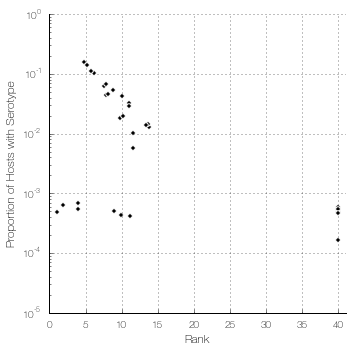

In [658]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.scatter(RANKS, proportions, c='k')
ax.set_xlim(0, NUM_SEROTYPES + 1)
ax.set_ylim(1e-5, 1)
ax.set_yscale('log')
ax.set_xlabel('Rank')
ax.set_ylabel('Proportion of Hosts with Serotype')
ax.grid()
remove_spines(ax)
fig.tight_layout()
#save_fig(fig, '{}-rank-frequencies'.format(run_name), exts=['pdf', 'png'])

#### Simpson Index

Formula is $1 - \sum_i p_i^2$, where $p_i$ is the proportion of colonized with serotype $i$.

In [659]:
def get_SI(min_age, max_age):
    return 1 - (get_proportions(NUM_COLONIZED[:,:,min_age:max_age].sum(axis=2)) ** 2).sum()

In [660]:
age_groups = [(i, i+1) for i in range(11)]
SIs = [get_SI(*g) for g in age_groups]

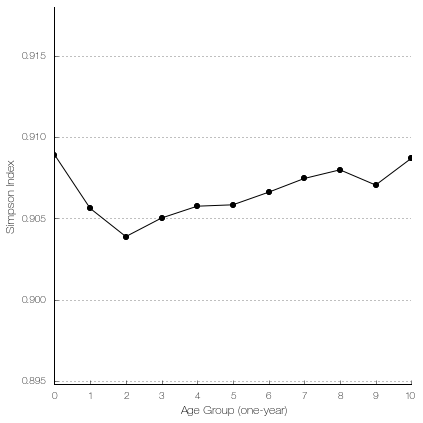

In [661]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.plot(np.arange(len(age_groups)), SIs, marker='o')
ax.set_xticks(np.arange(len(age_groups)))
ax.set_xticklabels(["{}".format(g[0]) for g in age_groups])
ax.set_ylim(min(SIs) * 0.99, max(SIs) * 1.01)
ax.set_xlabel('Age Group (one-year)')
ax.set_ylabel('Simpson Index')
ax.yaxis.grid(True)
remove_spines(ax)
fig.tight_layout()
#save_fig(fig, '{}-simpson-index'.format(run_name), exts=['pdf', 'png'])

#### Check Co-colonization (with multiple serotypes)

In [662]:
NUM_SEROTYPES_DIST_UNDER_5 = read_csv(TRIAL_DIR, 'num_serotypes_dist_under_5.csv')

['/Users/ocsicnarf/Github/Pneumo-Model/outputs/simulate-us-no-age-mixing-0.3-sg-4000-halflife/figures/trial-0/co-colonizations-0.pdf',
 '/Users/ocsicnarf/Github/Pneumo-Model/outputs/simulate-us-no-age-mixing-0.3-sg-4000-halflife/figures/trial-0/co-colonizations-0.png']

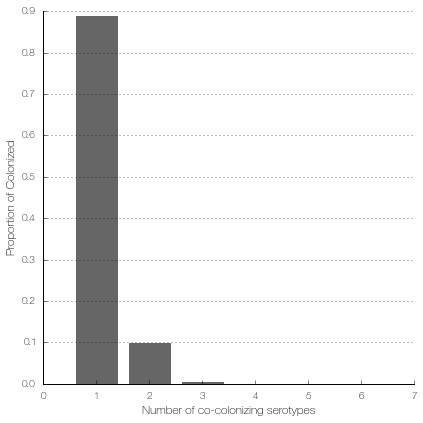

In [663]:
# take last row (sampling year) and consider only colonized
dist = NUM_SEROTYPES_DIST_UNDER_5[-1, 1:] 

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
w = 0.8
ax.bar(np.arange(len(dist)) + 1 - w / 2, dist.astype(float) / np.sum(dist), color='.4')
ax.set_ylabel('Proportion of Colonized')
ax.set_xlabel('Number of co-colonizing serotypes')
ax.yaxis.grid(True)
remove_spines(ax)
fig.tight_layout()
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(1))
save_fig(fig, 'co-colonizations', exts=['pdf', 'png'])

### Serotype Dynamics of Select Serotypes

['/Users/ocsicnarf/Github/Pneumo-Model/outputs/simulate-us-no-age-mixing-0.3-sg-4000-halflife/figures/trial-0/VT-vs-VRT-0.pdf',
 '/Users/ocsicnarf/Github/Pneumo-Model/outputs/simulate-us-no-age-mixing-0.3-sg-4000-halflife/figures/trial-0/VT-vs-VRT-0.png']

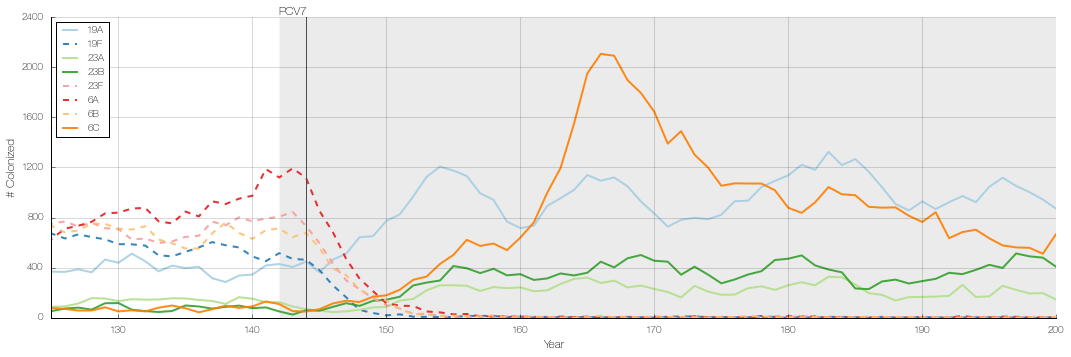

In [664]:
start, end = 125, 200
serotypes_to_plot = ['19A', '19F', '23A', '23B', '23F', '6A', '6B', '6C']

fig, ax = plt.subplots(1, 1, figsize=(15, 5))

for i, s in enumerate(serotypes_to_plot):            
    targeted = any(s in get_targeted_serotypes(p) for p in VACCINATION_PROGRAMS)
    idx = np.where(SEROTYPES == s)[0][0]
    ax.plot(NUM_COLONIZED_ALL_AGES[:, idx],
            label='{}'.format(s),
            color=PAIRED12_COLORS[i],
            ls=('--' if targeted else '-'),
            lw=2,
            alpha=0.9)
    

    ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(6))
    ax.legend(loc='upper left', frameon=True)
    ax.grid(True, ls='-', alpha=0.3)
    remove_spines(ax)

# add markers for vaccinations
for program in VACCINATION_PROGRAMS:
    ax.axvspan(get_program_start_year(program), get_program_end_year(program), facecolor='k', alpha=0.08)
    ax.text(get_program_start_year(program), ax.get_ylim()[1], program.vaccine,
            va='bottom', fontsize=12)
    ax.axvline(x=get_program_start_year(program) + 2, c='.3')

ax.set_xlim(start, end)
ax.set_xlabel('Year')
ax.set_ylabel('# Colonized')
fig.tight_layout()

save_fig(fig, 'VT-vs-VRT', exts=['pdf', 'png'])